In [0]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


In [0]:
df = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/within_covid.csv", parse_dates=['ds'])
df_covid = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/Covid.csv")

In [0]:
df_input = df.copy()

In [0]:
df_input['ds'] = pd.to_datetime(df_input['ds'])

In [0]:
df_activations = df_input[['ds', 'simulated']]
df_activations = df_activations.rename(columns = {'simulated':'activations'})
df_activations.head()

,ds,activations
0,2018-01-07 00:00:00+00:00,4893.0
1,2018-01-14 00:00:00+00:00,4695.0
2,2018-01-21 00:00:00+00:00,4510.0
3,2018-01-28 00:00:00+00:00,4760.0
4,2018-02-04 00:00:00+00:00,4467.0


In [0]:
before_covid_df = df_activations.iloc[0:113] ##from 2018-01-07 to 2020-03-01
in_covid_df = df_activations.iloc[113:217] ##from 2020-03-08 to 2022-02-27. >> two-year cycle
after_covid_df = df_activations.iloc[217:] ##from 2022-03-06 to 2022-08-28
no_covid_df = before_covid_df.append(after_covid_df)
print('before:',len(before_covid_df), ', in:',len(in_covid_df), ', after:', len(after_covid_df), ', no covid:', len(no_covid_df))
no_covid_df['ds'] = pd.date_range(start='2020-01-01', periods=139, freq='W')
df_activations = no_covid_df
df_activations_index = df_activations.set_index(['ds'])
df_activations

before: 113 , in: 104 , after: 26 , no covid: 139


,ds,activations
0,2020-01-05,4893.0
1,2020-01-12,4695.0
2,2020-01-19,4510.0
3,2020-01-26,4760.0
4,2020-02-02,4467.0
...,...,...
238,2022-07-31,10226.0
239,2022-08-07,9977.0
240,2022-08-14,10348.0
241,2022-08-21,10560.0


# Smooth Data

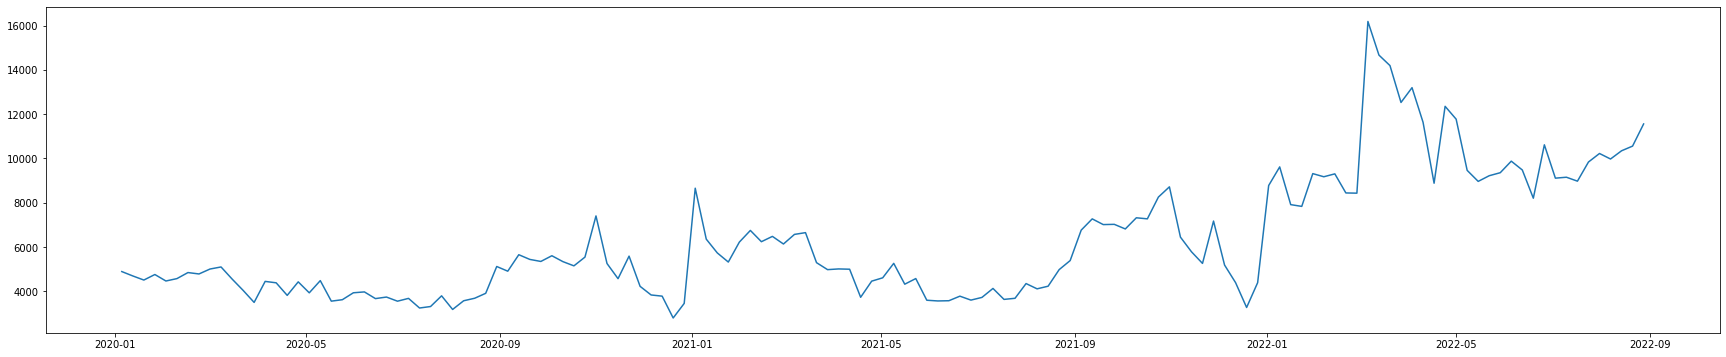

In [0]:
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize = (30, 6))
plt.plot(df_activations_index, label = 'activations')
plt.show()

## so we saw the trend of the cost

In [0]:
def test_ts(ts, w, title='test_ts'):
    roll_mean = ts.rolling(window = w).mean()
    roll_std = ts.rolling(window = w).std()
    pd_ewma = ts.ewm(com = 0.5).mean()
    
    plt.figure(figsize = (30, 5))
    plt.clf()
    plt.grid()
    plt.plot(ts, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.plot(pd_ewma, color='yellow', label = 'EWMA')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

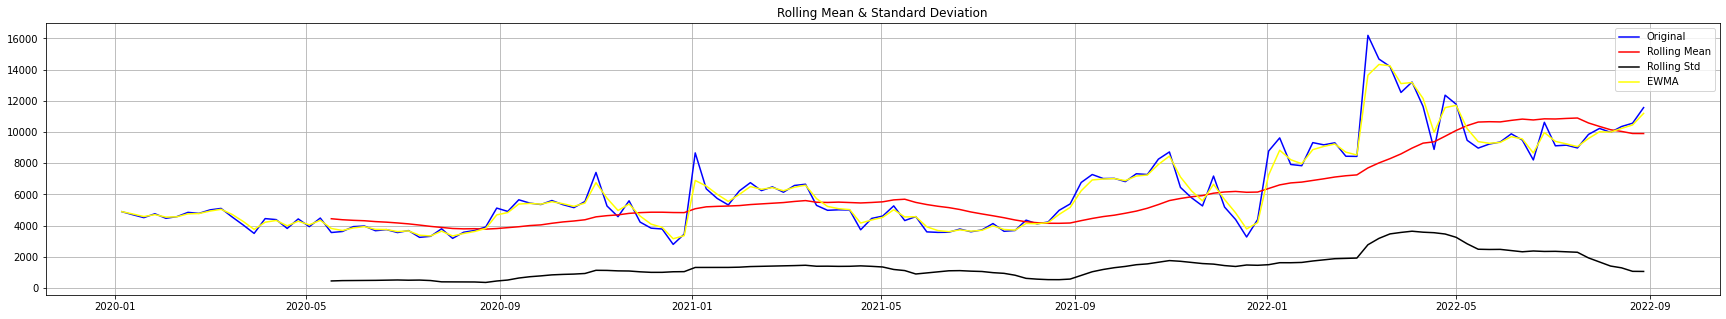

In [0]:
test_ts(df_activations_index, 20, title='test_org')

# Check Order

In [0]:
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(df_activations_index, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'{key}, {value:.2f}')
      
      
## The data is not stationary

ADF Statistic: -1.45
p-value: 0.56
Critial Values:
1%, -3.48
Critial Values:
5%, -2.88
Critial Values:
10%, -2.58


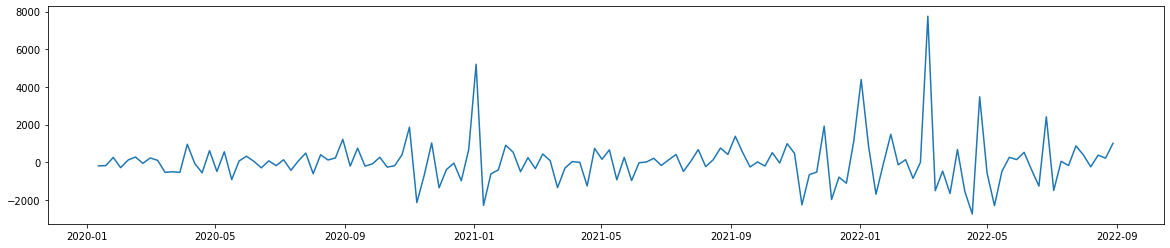

In [0]:
first_diff_cost = df_activations_index.diff()[1:]

plt.figure(figsize = (20, 4))
plt.plot(first_diff_cost, label = 'Diff #1')
plt.show()

In [0]:
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(first_diff_cost, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'{key}, {value:.2f}')

ADF Statistic: -5.00
p-value: 0.00
Critial Values:
1%, -3.48
Critial Values:
5%, -2.89
Critial Values:
10%, -2.58


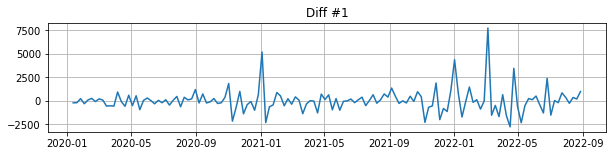

In [0]:
plt.figure(figsize=(10,2))
plt.plot(first_diff_cost)
plt.title('Diff #1')
plt.grid()
plt.show()

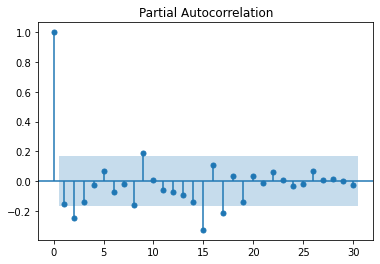

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(first_diff_cost, lags =30)
plt.show()

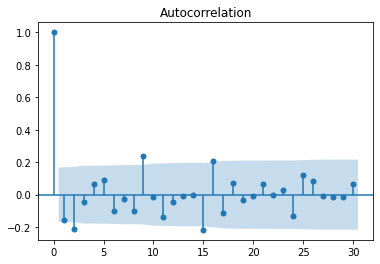

In [0]:
plot_acf(first_diff_cost, lags =30)
plt.show()

# Check Seasonal Order

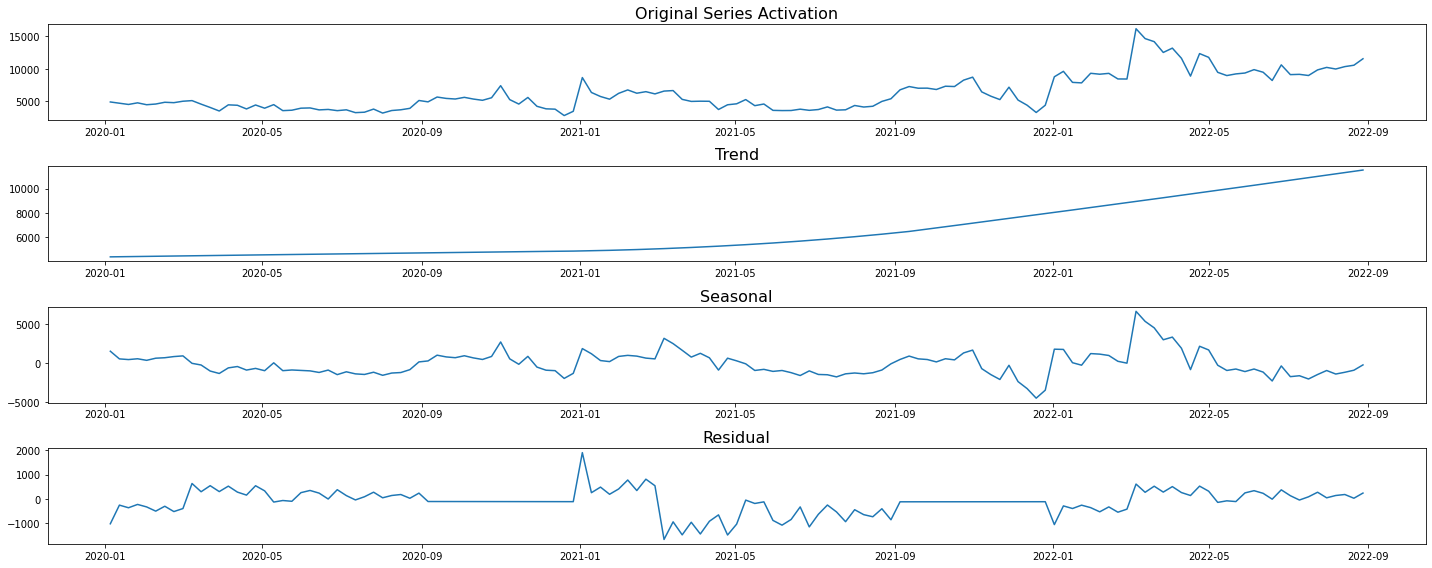

In [0]:
from statsmodels.tsa.seasonal import STL

stl_cost = STL(df_activations_index)
result_activation = stl_cost.fit()

seasonal_act, trend_act, resid_act = result_activation.seasonal, result_activation.trend, result_activation.resid

plt.figure(figsize=(20,8))


plt.subplot(4,1,1)
plt.plot(df_activations_index)
plt.title('Original Series Activation', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_act)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_act)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_act)
plt.title('Residual', fontsize=16)

plt.tight_layout()

In [0]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [0]:
check_stationarity(seasonal_act)

The series is stationary


In [0]:
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(seasonal_act, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'{key}, {value:.2f}')
      
      
## The data not stationary

ADF Statistic: -4.44
p-value: 0.00
Critial Values:
1%, -3.48
Critial Values:
5%, -2.88
Critial Values:
10%, -2.58


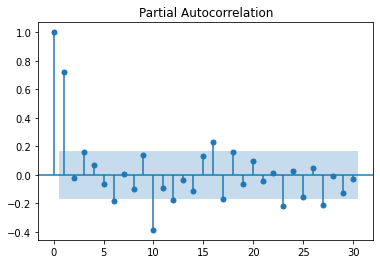

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal_act, lags =30)
plt.show()

# P could be:

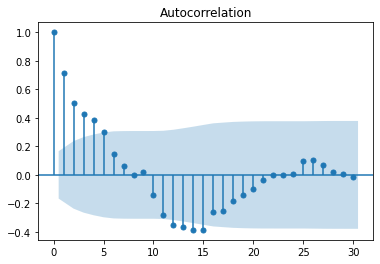

In [0]:
plot_acf(seasonal_act, lags =30)
plt.show()

# Q could be: 

In [0]:
train = df_activations_index.iloc[:int(len(df_activations_index)*0.9)]
validation = df_activations_index.iloc[int(len(df_activations_index)*0.9):int(len(df_activations_index)*0.95)]
test = df_activations_index.iloc[int(len(df_activations_index)*0.95):]

print("train:" + str(train.shape))
print("validation:" + str(validation.shape))
print("test:" + str(test.shape))

train:(125, 1)
validation:(7, 1)
test:(7, 1)


#MODEL BUILDING

In [0]:
mod = sm.tsa.statespace.SARIMAX(train['activations'],
                                order=(2, 1, 2), 
                                seasonal_order=(1, 1, 1, 12)
                                )

results = mod.fit()

print(results.summary().tables[1])

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3135      0.960      1.368      0.171      -0.568       3.195
ar.L2         -0.3699      0.616     -0.601      0.548      -1.577       0.837
ma.L1         -1.6014      1.007     -1.590      0.112      -3.576       0.373
ma.L2          0.6148      0.862      0.713      0.476      -1.074       2.304
ar.S.L12      -0.1168      0.176     -0.665      0.506      -0.461    

In [0]:
train_pred = results.predict(start=train.index[0], end=train.index[int(len(train))-1], dynamic=False)
#pred_ci = pred.conf_int()

In [0]:
val_pred = results.predict(start=validation.index[0], end=validation.index[int(len(validation))-1], dynamic=False)
#pred_ci = pred.conf_int()

                 0
count   125.000000
mean     49.420663
std    1375.663687
min   -2969.159154
25%    -667.139897
50%       2.716092
75%     451.085232
max    7979.850429


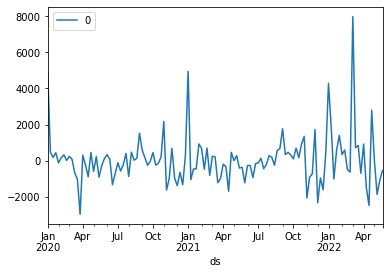

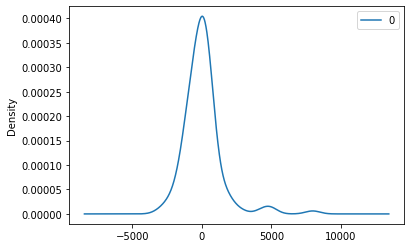

In [0]:
# line plot of residuals
residuals = pd.DataFrame(results.resid)
residuals.plot()
# density plot of residuals
residuals.plot(kind='kde')
# summary stats of residuals
print(residuals.describe())

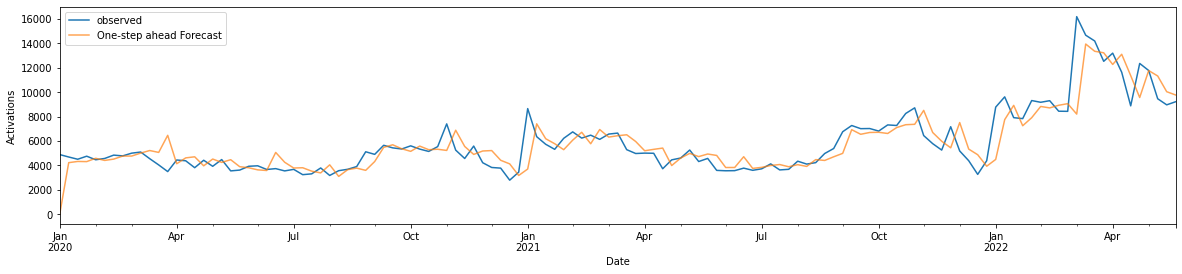

In [0]:
plt.figure(figsize = (20, 4))

ax = train['activations'].plot(label='observed')
train_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

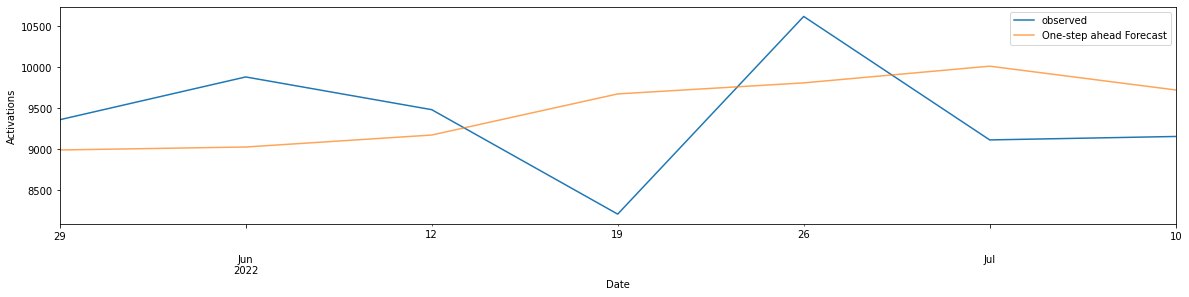

In [0]:
plt.figure(figsize = (20, 4))

ax = validation['activations'].plot(label='observed')
val_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

In [0]:
y_forecasted = train_pred
y_truth = train

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error

print("MAPE: " + str(mean_absolute_percentage_error(y_truth, y_forecasted)))
print("r2: " + str(r2_score(y_truth, y_forecasted)))
print("RMSE: " + str(mean_squared_error(y_truth, y_forecasted, squared=False)))

MAPE: 0.14685469825827951
r2: 0.7229853344792725
RMSE: 1371.0409827531896


In [0]:
y_forecasted = val_pred
y_truth = validation

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error

print("MAPE: " + str(mean_absolute_percentage_error(y_truth, y_forecasted)))
print("r2: " + str(r2_score(y_truth, y_forecasted)))
print("RMSE: " + str(mean_squared_error(y_truth, y_forecasted, squared=False)))

MAPE: 0.08202132547586825
r2: -0.4893540383129227
RMSE: 836.5235546726645


#TEST

In [0]:
train_validation = df_activations_index.iloc[:len(train) + len(validation)]

print("train_validation:" + str(train_validation.shape))

train_validation:(132, 1)


In [0]:
mod = sm.tsa.statespace.SARIMAX(train_validation['activations'],
                                order=(2, 1, 2), 
                                seasonal_order=(1, 1, 1, 12)
                                )

results_test = mod.fit()

print(results.summary().tables[1])

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/databricks/python/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3135      0.960      1.368      0.171      -0.568       3.195
ar.L2         -0.3699      0.616     -0.601      0.548      -1.577       0.837

In [0]:
test_pred = results_test.predict(start=test.index[0], end=test.index[int(len(test))-1], dynamic=False)

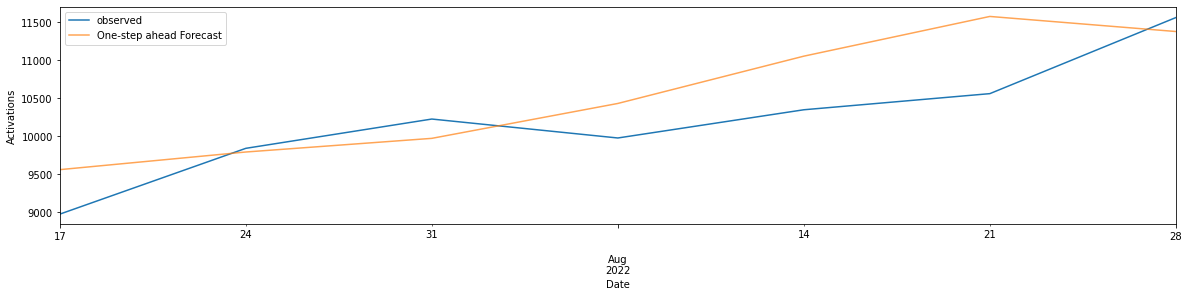

In [0]:
plt.figure(figsize = (20, 4))

ax = test['activations'].plot(label='observed')
test_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

In [0]:
y_forecasted = test_pred
y_truth = test

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error

print("MAPE: " + str(mean_absolute_percentage_error(y_truth, y_forecasted)))
print("r2: " + str(r2_score(y_truth, y_forecasted)))
print("RMSE: " + str(mean_squared_error(y_truth, y_forecasted, squared=False)))

MAPE: 0.045776774429503085
r2: 0.40851853881563593
RMSE: 557.4366389686106


In [0]:
full_pre = train_pred.append([val_pred, test_pred]).to_frame(name='forecasted_activations')
full_pre.index.name = 'ds'
full_pre

,forecasted_activations
ds,
2020-01-05,0.000000
2020-01-12,4230.222960
2020-01-19,4330.039206
2020-01-26,4316.613640
2020-02-02,4589.150138
...,...
2022-07-31,9972.174464
2022-08-07,10430.943802
2022-08-14,11052.744497


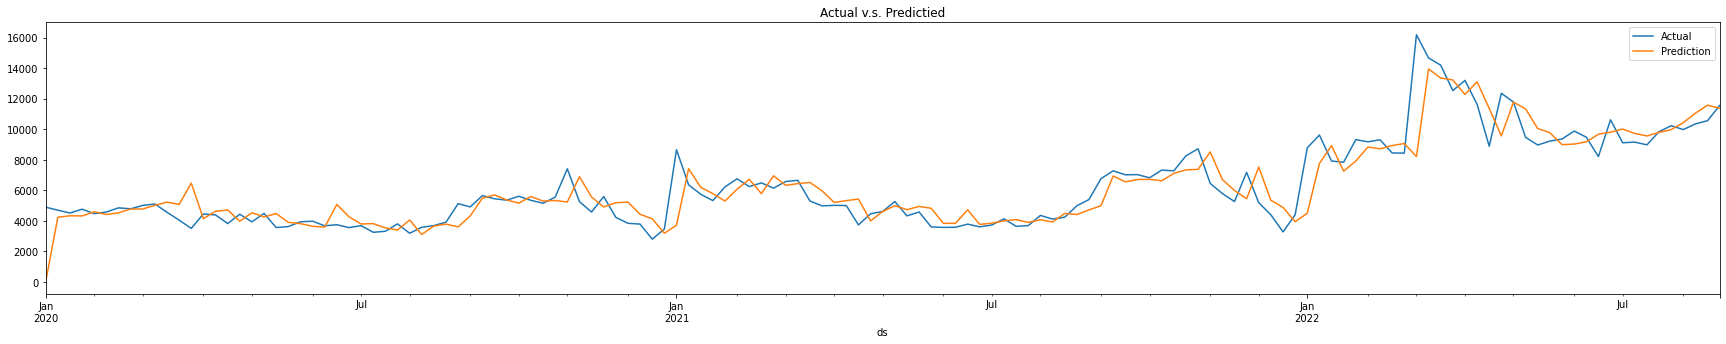

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

df_activations.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
full_pre.reset_index().plot(kind='line',x='ds', y='forecasted_activations', label='Prediction', ax=ax)
plt.title('Actual v.s. Predictied')
plt.legend()
plt.show()

# FORECASTING

In [0]:
mod = sm.tsa.statespace.SARIMAX(df_activations_index['activations'],
                                order=(2, 1, 2), 
                                seasonal_order=(1, 1, 1, 12)
                                )

results = mod.fit()

print(results.summary().tables[1])

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7143      0.097      7.352      0.000       0.524       0.905
ar.L2         -0.9662      0.100     -9.664      0.000      -1.162      -0.770
ma.L1         -0.7752      0.116     -6.689      0.000      -1.002      -0.548
ma.L2          0.9750      0.159      6.143      0.000       0.664       1.286
ar.S.L12       0.0252      0.136      0.185      0.853      -0.242    

In [0]:
covid_df = pd.date_range(start = '2022-09-01', end = '2022-12-31', freq = 'W').to_frame()
covid_df['cases'] = 0

In [0]:
exog_forecast = covid_df[['cases']]

pred_fc = results.get_forecast(steps = len(covid_df), dynamic=True, exog = exog_forecast)

# confident level
pred_ci = pred_fc.conf_int()

In [0]:
prediction = {
  #'ds' : pd.date_range(start = '2022-06-01', periods = len(pred_fc.predicted_mean)),
  'activation_planned_cost' : pred_fc.predicted_mean
}

prediction_cost = pd.DataFrame(prediction)
prediction_cost.tail(10)

,activation_planned_cost
2022-10-23,12497.223726
2022-10-30,12092.842256
2022-11-06,12102.030682
2022-11-13,12643.538665
2022-11-20,13047.868479
2022-11-27,13242.911972
2022-12-04,13064.798121
2022-12-11,13070.087601
2022-12-18,12953.514099
2022-12-25,12848.441745


<Figure size 1440x288 with 0 Axes>

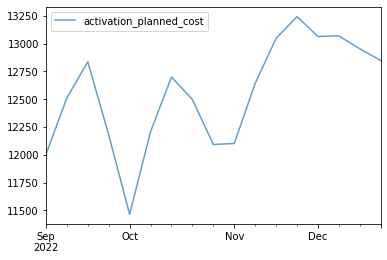

In [0]:
plt.figure(figsize = (20, 4))

prediction_cost.plot(label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

In [0]:
prediction_cost = prediction_cost.reset_index()
prediction_cost.columns = ['ds', 'activations']
prediction_cost = prediction_cost[['ds', 'activations']]
prediction_cost.head(5)

,ds,activations
0,2022-09-04,12001.631010
1,2022-09-11,12512.734327
2,2022-09-18,12836.452068
3,2022-09-25,12178.885026
4,2022-10-02,11464.942667


##Do

In [0]:
future_real = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/W_input.csv", parse_dates=['ds'])
future_real = future_real[['ds', 'simulated']]
future_real.head()

,ds,simulated
0,2022-08-07 00:00:00+00:00,9530
1,2022-08-14 00:00:00+00:00,9602
2,2022-08-21 00:00:00+00:00,10011
3,2022-08-28 00:00:00+00:00,10759
4,2022-09-04 00:00:00+00:00,13129


In [0]:
future_real = future_real[future_real['ds'] > '2022-09-01']
# future_real_df = future_real_df[['ds', '']]
future_real_df_index = future_real.set_index(['ds'])
future_real_df_index

,simulated
ds,
2022-09-04 00:00:00+00:00,13129
2022-09-11 00:00:00+00:00,13101
2022-09-18 00:00:00+00:00,11780
2022-09-25 00:00:00+00:00,10800
2022-10-02 00:00:00+00:00,10426
2022-10-09 00:00:00+00:00,11367
2022-10-16 00:00:00+00:00,11168
2022-10-23 00:00:00+00:00,11180
2022-10-30 00:00:00+00:00,11349


In [0]:
forecast_df = prediction_cost[prediction_cost['ds'] > '2022-09-01']
forecast_df = prediction_cost[prediction_cost['ds'] < '2022-11-27'].set_index(['ds'])
forecast_df

,activations
ds,
2022-09-04,12001.631010
2022-09-11,12512.734327
2022-09-18,12836.452068
2022-09-25,12178.885026
2022-10-02,11464.942667
2022-10-09,12209.844855
2022-10-16,12700.116934
2022-10-23,12497.223726
2022-10-30,12092.842256


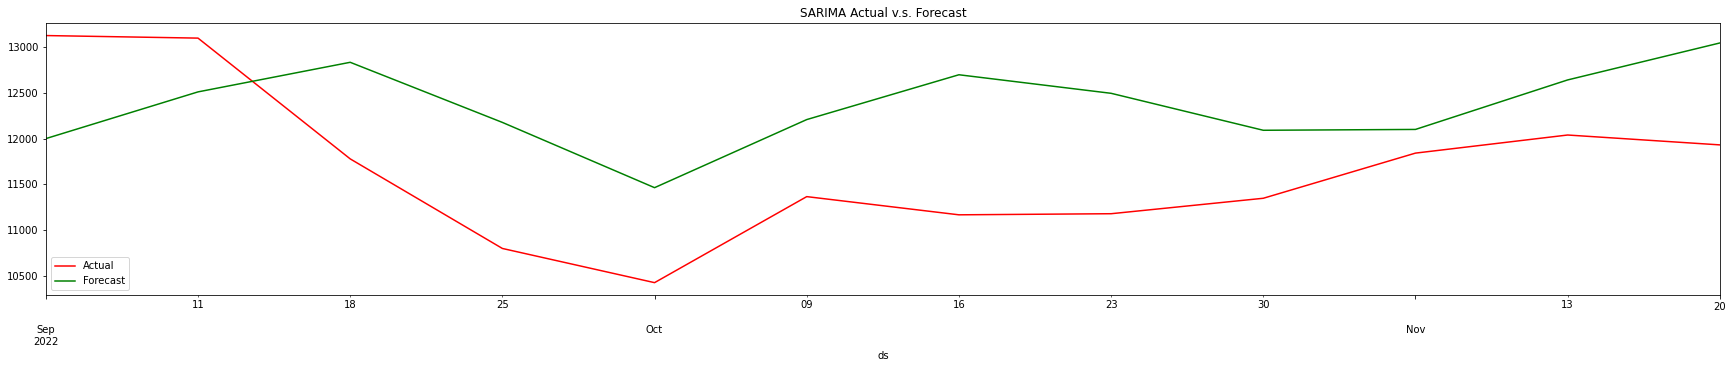

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

future_real_df_index.plot(kind='line',y='simulated', color='red', label='Actual', ax=ax)
forecast_df.plot(kind='line',y='activations', color='green',label='Forecast', ax=ax)
plt.title('SARIMA Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = future_real_df_index
y_pred = forecast_df

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.08398460294226112
r2: -0.7169311217786767
RMSE 1030.0916202310045
